CARGANDO EL DATASET

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


EXTRAYENDO INFORMACIÓN DEL DATASET

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

ELIMINANDO COLUMNAS QUE NO SE OCUPAN, O NO SE PUEDEN PROCESAR

In [3]:
to_drop = [
    'Date',
    'Location',
    'WindGustDir',
    'WindDir9am',
    'WindDir3pm',
    'RainToday',
    'RISK_MM'
]

df.drop(to_drop, inplace=True, axis=1)

RELLENANDO TODOS LOS CAMPOS VACIOS CON 0, Y ALTERANDO LA COLUMNA 'RainTomorrow' DE 'Yes'/'No' A 1/-1 YA QUE ESTA COLUMNA ES LA QUE SERÁ UTILIZADA COMO TARGET

In [4]:
cleaned = df.fillna(0)
cleaned = cleaned.replace({'RainTomorrow' : {'No':-1, 'Yes':1}})

MATRIZ DE CORRELACION

In [5]:
rs = np.random.RandomState(0)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1,0.736267,0.104255,0.467261,0.0729613,0.177285,0.176005,0.175749,-0.234211,0.00599903,-0.45126,-0.461623,0.0776249,0.0204888,0.901813,0.708865
MaxTemp,0.736267,1,-0.074839,0.588915,0.469967,0.0676901,0.0146804,0.0507999,-0.505432,-0.50927,-0.332293,-0.427279,-0.289865,-0.279053,0.88702,0.984562
Rainfall,0.104255,-0.074839,1,-0.0645494,-0.227525,0.133497,0.0868158,0.057759,0.223725,0.255312,-0.168085,-0.126728,0.198195,0.171993,0.0114774,-0.0791776
Evaporation,0.467261,0.588915,-0.0645494,1,0.366607,0.203001,0.193936,0.128895,-0.50589,-0.392785,-0.269907,-0.29316,-0.185032,-0.184287,0.545497,0.574275
Sunshine,0.0729613,0.469967,-0.227525,0.366607,1,-0.0328309,0.00803964,0.0560117,-0.491603,-0.629122,0.0409589,-0.0204637,-0.67561,-0.704202,0.291139,0.49018
WindGustSpeed,0.177285,0.0676901,0.133497,0.203001,-0.0328309,1,0.604837,0.686419,-0.215461,-0.0266629,-0.457891,-0.412922,0.0712355,0.109088,0.150258,0.0329697
WindSpeed9am,0.176005,0.0146804,0.0868158,0.193936,0.00803964,0.604837,1,0.519971,-0.270807,-0.0316075,-0.227923,-0.174916,0.0242804,0.0535843,0.129298,0.00510815
WindSpeed3pm,0.175749,0.0507999,0.057759,0.128895,0.0560117,0.686419,0.519971,1,-0.145942,0.0159032,-0.295567,-0.254988,0.0527796,0.0252686,0.163601,0.0285673
Humidity9am,-0.234211,-0.505432,0.223725,-0.50589,-0.491603,-0.215461,-0.270807,-0.145942,1,0.667388,0.139519,0.186955,0.452182,0.358043,-0.472826,-0.499777
Humidity3pm,0.00599903,-0.50927,0.255312,-0.392785,-0.629122,-0.0266629,-0.0316075,0.0159032,0.667388,1,-0.0274495,0.0518397,0.517037,0.52327,-0.221467,-0.557989


DIVIDENDO EL DATASET, Y TRANSFORMANDOLO

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = cleaned.iloc[:,:-1].values, cleaned.iloc[:,-1].values

train, test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(train)
X_test_std = sc.transform(test)

APLICANDO LDA AL DATASET DE ENTRENAMIENTO Y PRUEBAS

In [7]:
from plot_regions import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
lda.coef_

array([[ 0.22143794,  0.62211171,  0.35033181,  0.04502691, -0.30629168,
         0.64971539, -0.02967113, -0.21893777, -0.05340989,  1.07086444,
         0.15185326, -0.22974468,  0.06404951,  0.34982763,  0.01689207,
        -0.83730499]])

In [8]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=5, random_state=0)

APLICANDO LA VALIDACION CRUZADA

In [10]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=classifier, X=X_train_lda, y=y_train, cv=5)

In [11]:
print(all_accuracies.mean())

0.7619832219822174


CONFIGURANDO PARAMETROS DE GridSearch

In [12]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_estimators': [1, 3, 5, 8, 10],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

gd_sr = GridSearchCV(estimator=classifier,
                    param_grid=grid_params,
                    scoring='accuracy',
                    cv=5,
                    n_jobs=-1)

ENTRENANDO ...

In [14]:
gd_sr.fit(X_train_lda, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1, 3, 5, 8, 10], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

MOSTRANDO RESULTADOS

In [15]:
best_parameters= gd_sr.best_params_
print(best_parameters)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 8}


In [16]:
best_result = gd_sr.best_score_
print(best_result)

0.7678404581303059


(array([9.0000e+00, 8.4600e+02, 3.5729e+04, 4.8621e+04, 1.3058e+04,
        1.1350e+03, 1.0100e+02, 2.0000e+01, 1.3000e+01, 3.0000e+00]),
 array([-5.63250194, -3.91788084, -2.20325973, -0.48863863,  1.22598248,
         2.94060358,  4.65522469,  6.3698458 ,  8.0844669 ,  9.79908801,
        11.51370911]),
 <a list of 10 Patch objects>)

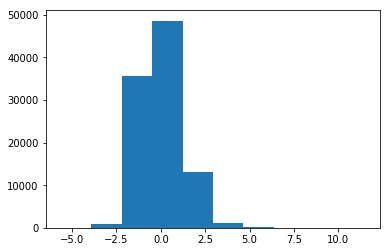

In [20]:
import matplotlib.pyplot as plt

plt.hist(X_train_lda)

In [22]:
gd_sr.cv_results_

/home/miguelruiz/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/miguelruiz/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/miguelruiz/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/miguelruiz/.local/lib/

{'mean_fit_time': array([ 1.2618176 ,  3.5991046 ,  5.99156466,  9.52155099, 11.8043961 ,
         2.55041995,  7.90758815, 13.07849483, 20.23731518, 25.67831893,
         1.93274488,  5.70996175,  9.47746654, 14.92262673, 19.01176829,
         4.90951681, 14.71587691, 24.46770554, 38.79917002, 45.53279314]),
 'std_fit_time': array([0.06482442, 0.02739176, 0.07178753, 0.25920788, 0.21840894,
        0.09143085, 0.0819919 , 0.47142721, 0.49058911, 0.37496991,
        0.06825297, 0.20436311, 0.41755108, 0.5205347 , 0.66376887,
        0.20700739, 0.61381941, 1.07198574, 1.6963531 , 6.44899436]),
 'mean_score_time': array([0.03549495, 0.08413577, 0.12926245, 0.19587131, 0.24879923,
        0.03484755, 0.08680758, 0.14301906, 0.21343193, 0.26973305,
        0.03894382, 0.09752874, 0.15507169, 0.2459969 , 0.30953336,
        0.04761238, 0.11812563, 0.18707871, 0.28772297, 0.32097564]),
 'std_score_time': array([0.00565255, 0.01567462, 0.00568815, 0.00868831, 0.00436324,
        0.00381058, 